In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot


In [2]:


def t_from_x(x):
    return jnp.log(1/x)


def construct_cdf(function):

    def cdf(x, alpha, params):
        t = t_from_x(x)
        return jnp.nan_to_num(jnp.exp(-function(t, alpha, params)))
    return cdf



def construct_pdf(function):

    cdf = construct_cdf(function)
    derivative = jax.grad(cdf, argnums=0)

    def pdf(x, alpha, params):
        return jnp.nan_to_num(derivative(x, alpha, params) )

    return pdf







In [3]:
print(polynomial(5, 5, jnp.array([[1,1]])))

derivative = jax.grad(polynomial, argnums=0)
print(derivative(0.0, 0.0, jnp.array([[0,], [1,]])))

derivative2 = jax.grad(derivative, argnums=0)
print(derivative2(0.0, 0.0, jnp.array([[1,]])))

derivative3 = jax.grad(derivative2, argnums=0)
print(derivative3(0.0, 0.0, jnp.array([[1.0, 0.0] ])))

# derivative4 = jax.grad(derivative3, argnums=0)
# print(derivative4(0.0, 0.0, integral_coeffs[:2,:2]))




No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


6.0
0.0
0.0
0.0


In [26]:
from scipy.signal import convolve2d

def polynomial_multiply(c1, c2, M = None, N = None):

    if M is None:
        M = c1.shape[0] + c2.shape[0]
    if N is None:
        N = c1.shape[1] + c2.shape[1]

    full_conv = convolve2d(c1, c2, mode='full')
    truncated = full_conv
    return truncated



def polynomial_sum(cs):

    # zero pad to the same size
    max_M = max([c.shape[0] for c in cs])
    max_N = max([c.shape[1] for c in cs])

    for i in range(len(cs)):
        M = cs[i].shape[0]
        N = cs[i].shape[1]
        cs[i] = jnp.pad(cs[i], ((0, max_M - M), (0, max_N - N)), mode='constant')

    cs = jnp.array(cs)
    return jnp.sum(cs, axis=0)

def polynomial_power(c, k):
    
    if k == 0:
        return jnp.array([[1,]])
    elif k == 1:
        return c
    else:
        return polynomial_multiply(c, polynomial_power(c, k-1))

c1 = jnp.array([[1,], [1,]])
c2 = jnp.array([[1, 1,]])
print(polynomial_multiply(c1, c2, 1, 1))
print(polynomial_sum([c1, c2]))
print(polynomial_power(c1, 4))


[[1 1]
 [1 1]]
[[2 1]
 [1 0]]
[[1]
 [4]
 [6]
 [4]
 [1]]


In [ ]:




def integrate_taylor_polynomial(c):
  

    M_plus_1, N_plus_1 = c.shape
    M = M_plus_1 - 1
    N = N_plus_1 - 1
    
    # New array will have shape (M+1, N+2)
    d = np.zeros((M_plus_1, N_plus_1 + 1), dtype=c.dtype)
    
    # d[m,n] = c[m,n-1]/n, except d[m,0] = 0.
    for m in range(M_plus_1):
        for n in range(1, N+2):
            d[m, n] = c[m, n-1] / n

    return d


def example_f(t, alpha, params):
    return alpha *( t )   



M = 5
N = 5
coeffs = taylor_expand_2d(example_f, 0.0, 0.0, M, N)
integral_coeffs = integrate_taylor_polynomial(coeffs)

def matching_coeffs(f, M, N):

    coeffs = taylor_expand_2d(f, 0.0, 0.0, M, N)
    integral_coeffs = integrate_taylor_polynomial(coeffs)

    K = M + N

    print(polynomial_power(integral_coeffs, 1))
    print(polynomial_power(integral_coeffs, 2))
    print(polynomial_power(integral_coeffs, 3))

    polynomial_coeffs = polynomial_sum([polynomial_power(integral_coeffs, k+1) / (k+1) for k in range(K+1)])
    return polynomial_coeffs

    # @jax.jit
    def temp(t, alpha, params):

        # print(polynomial_power(integral_coeffs, 3))
        polynomial_coeffs = -polynomial_sum([polynomial_power(integral_coeffs, k+1) / (k+1) for k in range(K)])

        # Compute -x - x2/2 - x3/3 - ... - xK/K = log(1-x)
        return polynomial(t, alpha, polynomial_coeffs)

    
    return -1 * taylor_expand_2d(temp, 0.0, 0.0, M, N)

# matched_coeffs = matching_coeffs(example_f, 3, 3)

# print(coeffs)
# print(integral_coeffs)
print(matching_coeffs(example_f, 4, 4))



/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:72: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


[[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]]
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.125 0. 

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.5 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


NameError: name 'polynomial_f' is not defined

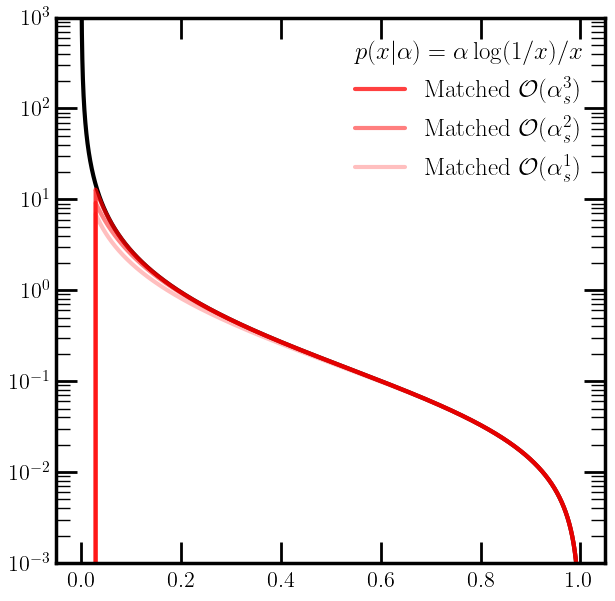

In [31]:
alpha = 0.118

x = jnp.linspace(0, 1, 10000)
t = t_from_x(x)
matched_coeffs = matching_coeffs(example_f, 3, 6)
print(matched_coeffs)

pdf = construct_pdf(polynomial)
pdf = jax.vmap(pdf, in_axes=(0, None, None))

fig, ax = newplot("full")


ax.plot(x, alpha * jnp.log(1/x) / x, color = 'black', ls = "-")
# ax.plot(x, alpha * jnp.log(1/x) / x * jnp.exp( -alpha / 2 * jnp.log(1/x)**2), color = 'grey', ls = "-")



# ax.plot(x, polynomial_f(t, alpha, coeffs) / x, label="Original", color = "black")
# ax.plot(x, pdf(x, alpha, matched_coeffs[:4 + 1]), label=r"Matched $\mathcal{O}(\alpha_s^4)$", color = "red")
ax.plot(x, pdf(x, alpha, matched_coeffs[:3 + 4]), label=r"Matched $\mathcal{O}(\alpha_s^3)$", color = "red", alpha = 0.75)
ax.plot(x, pdf(x, alpha, matched_coeffs[:2 + 1]), label=r"Matched $\mathcal{O}(\alpha_s^2)$", color = "red", alpha = 0.5)
ax.plot(x, pdf(x, alpha, matched_coeffs[:1 + 1]), label=r"Matched $\mathcal{O}(\alpha_s^1)$", color = "red", alpha = 0.25)




plt.yscale("log")
plt.ylim(1e-3, 1e3)

plt.legend(title=r"$p(x|\alpha) =\alpha\log(1/x)/x$")


# Plot the CDFs
cdf = construct_cdf(polynomial_f)
cdf = jax.vmap(cdf, in_axes=(0, None, None))

fig, ax = newplot("full")
# ax.plot(x, polynomial_f(t, alpha, integral_coeffs), label="Original", color = "black")
ax.plot(x, cdf(x, alpha, matched_coeffs), label=r"Matched $\mathcal{O}(\alpha_s^3)$", color = "red")
ax.plot(x, cdf(x, alpha, matched_coeffs[:-1]), label=r"Matched $\mathcal{O}(\alpha_s^2)$", color = "red", alpha = 0.5)
ax.plot(x, cdf(x, alpha, matched_coeffs[:-2]), label=r"Matched $\mathcal{O}(\alpha_s^1)$", color = "red", alpha = 0.25)

# ax.plot(x, 1- alpha * jnp.log(1/x) ** 2, color = 'black', ls = "-")
ax.plot(x, jnp.exp( -alpha / 2 * jnp.log(1/x)**2), color = 'pink', ls = "--")